# Preprocessing

## Import

In [1]:
import glob
import numpy as np
import pandas as pd
import subprocess
import os

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# from config import DATA_DIR, SCRIPTS_DIR, STRUCTURES_DIR
# from utils.generic_utils import remove_abc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Path

In [3]:
current_dir = '/content/drive/MyDrive/Colab Notebooks'

df_path = os.path.join(current_dir, 'test_data', 'sabdab_summary_all.tsv')
residues_path = os.path.join(current_dir, 'test_data', 'lists_of_residues')
structures_path = os.path.join(current_dir, 'all_structures', 'chothia')
dccm_map_path = os.path.join(current_dir, 'test_data', 'dccm_maps')
scripts_path = os.path.join(current_dir, 'scripts')
file_residues_paths = sorted(glob.glob(os.path.join(residues_path, '*.npy')))
chain_lengths_path = os.path.join(current_dir, 'test_data', 'chain_lengths')

## Clean df

In [4]:
def clean_df(df_path, pathological, affinity_entries_only=True):
    """
    Cleans the database containing the PDB entries.

    Parameters:
    - df_path: str
        Path to the database file.
    - pathological: list
        PDB identifiers of antibodies that need to be excluded.
    - affinity_entries_only: bool
        If True, only consider data with affinity values.

    Returns:
    - df_pdbs: list
        PDB entries.
    - df_kds: list
        Binding affinities.
    - df: pandas.DataFrame
        Cleaned database.
    """
    # Read the database
    df = pd.read_csv(df_path, sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]

    # Remove duplicates
    df.drop_duplicates(keep='first', subset='pdb', inplace=True)

    # Convert PDB identifiers to lowercase and remove '+' signs
    df['pdb'] = df['pdb'].str.lower().str.replace('+', '')

    # Filter entries based on antigen type
    df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]

    # If only entries with affinity are considered
    if affinity_entries_only:
        df = df[(df.affinity.notna()) & (df.affinity != 'None')]

    # Exclude pathological cases
    df = df[~df['pdb'].isin(pathological)]

    # df = df[:30]

    return list(df['pdb']), list(df['affinity']), df

In [5]:
pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf']
pathological += scfv

entries, affinity, df = clean_df(df_path, pathological)

In [6]:
df

,pdb,affinity
0,6fe4,9.600000e-09
5,5w08,4.000000e-08
11,2ny3,8.150000e-07
12,6h7o,1.400000e-10
14,1nca,8.300000e-09
...,...,...
1259,5d70,2.000000e-09
1260,2p48,1.160000e-07
1261,4zfg,5.000000e-09
1263,3idx,4.040000e-09


## generate fv pdb

#### generate_fv_pdb

In [7]:
def generate_fv_pdb(path, residues_path, stage='training', selection='_fv', affinity_entries_only=True, alphafold=False, ag_agnostic=False, cmaps=False,
                    keepABC=True, lresidues=False, hupsymchain=None, lupsymchain=None):
        r"""Generates a new PDB file going from the beginning of the CDR1 until the end of the CDR3.

        Parameters
        ----------
        path: str
            Path of a Chothia-numbered PDB file.
        keepABC: bool
            Keeps residues whose name ends with a letter from 'A' to 'Z'.
        lresidues: bool
            The names of each residue are stored in ``self.residues_path``.
        upsymchain: int
            Upper limit of heavy chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.
        lupsymchain: int
            Upper limit of light chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.

        """
        if stage == 'training':
            rpath = residues_path
        else:
            rpath = test_residues_path
        list_residues = ['START']

        with open(path, 'r') as f: # needs to be Chothia-numbered
            content = f.readlines()
            header_lines_important = range(4)
            header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
            h_range = range(1, 114)
            l_range = range(1, 108)
            start_chain = 21
            chain_range = slice(start_chain, start_chain+1)
            res_range = slice(23, 26)
            res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
            h_chain_key = 'HCHAIN'
            l_chain_key = 'LCHAIN'
            antigen_chain_key = 'AGCHAIN'
            idx_list = list(header_lines_important)
            idx_list_l = []
            idx_list_antigen = []
            antigen_chains = []
            new_path = path[:-4] + selection + path[-4:]
            # Getting the names of the heavy and antigen chains
            line = content[header_lines_important[-1]]
            if line.find(h_chain_key) != -1:
                h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
                h_chain = line[h_pos:h_pos+1]
                antigen_pos = line.find(antigen_chain_key) + len(antigen_chain_key) + 1
                antigen_chains.append(line[antigen_pos:antigen_pos+1])
                for i in range(3):
                    if line[antigen_pos+2*i+1] in [',', ';']:
                        antigen_chains.append(line[antigen_pos+2*i+2]) # If two (or more) interacting antigen chains present
            else:
                # useful when using AlphaFold
                h_chain = 'A'
                l_chain = 'B'
                antigen_chains = ['C', 'D', 'E']
                idx_list = [0]
                h_range = range(1-self.h_offset, hupsymchain-self.h_offset)
                l_range = range(1-self.l_offset, lupsymchain-self.l_offset)
                h_pos = start_chain
                l_pos = start_chain

            if line.find(l_chain_key) != -1:
                l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
                l_chain = line[l_pos:l_pos+1]
            elif alphafold is False:
                l_chain = None

            # Checking if H and L chains have the same name
            if l_chain is not None and h_chain.upper() == l_chain.upper():
                pathologic = True
                h_chain = h_chain.upper()
                l_chain = h_chain.lower()
            elif antigen_chains is not None and affinity_entries_only is False and (h_chain.upper() in antigen_chains or (l_chain is not None and l_chain.upper() in antigen_chains)):
                pathologic = True
                h_chain = h_chain.lower()
                if l_chain is not None:
                    l_chain = l_chain.lower()
            else:
                pathologic = False

            # Checks for matching identifiers
            if pathologic:
                if 'X' not in antigen_chains:
                    new_hchain = 'X'
                else:
                    new_hchain = 'W'
                if 'Y' not in antigen_chains:
                    new_lchain = 'Y'
                else:
                    new_lchain = 'Z'
            else:
                new_hchain = h_chain
                new_lchain = l_chain

            # Obtaining lines for the heavy chain variable region first
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                    if (line[res_extra_letter] == ' ' or keepABC == True) and line.find('HETATM') == -1:
                        idx_list.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[res_range] + line[res_extra_letter]
                            if pathologic:
                                full_res = new_hchain + full_res
                            else:
                                full_res = line[chain_range] + full_res
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)

            # This separation ensures that heavy chain residues are enlisted first
            if l_chain is not None:
                for i, line in enumerate(content[header_lines:]):
                    if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
                        if (line[res_extra_letter] == ' ' or keepABC == True) and line.find('HETATM') == -1:
                            idx_list_l.append(i+header_lines)
                            if lresidues == True:
                                full_res = line[res_range] + line[res_extra_letter]
                                if pathologic:
                                    full_res = new_lchain + full_res
                                else:
                                    full_res = line[chain_range] + full_res
                                if full_res != list_residues[-1]:
                                    list_residues.append(full_res)

            # Obtaining antigen(s)
            for i, line in enumerate(content[header_lines:]):
                if any(line[chain_range] in agc for agc in antigen_chains) and h_chain not in antigen_chains and l_chain not in antigen_chains:
                    idx_list_antigen.append(i+header_lines)

        # List with name of every residue is saved if selected
        if lresidues == True:
            list_residues.append('END')
            saving_path = rpath + path[-8:-4] + '.npy'
            #if not os.path.exists(saving_path):
            np.save(saving_path, list_residues)

        # Creating new file
        with open(new_path, 'w') as f_new:
            f_new.writelines([content[l] for l in idx_list[:header_lines_important[-1]]])
            if l_chain is not None and alphafold is False:
                f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:l_pos]+new_lchain+content[l][l_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
            else:
                f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
            f_new.writelines([content[l][:start_chain-5]+' '+content[l][start_chain-4:start_chain]+new_hchain+content[l][start_chain+1:] for l in idx_list[header_lines_important[-1]+1:]])
            if l_chain is not None:
                f_new.writelines([content[l][:start_chain-5]+' '+content[l][start_chain-4:start_chain]+new_lchain+content[l][start_chain+1:] for l in idx_list_l])
            if not ag_agnostic:
                f_new.writelines([content[l] for l in idx_list_antigen])
            if not cmaps:
                f_new.writelines([content[l] for l in range(len(content)) if content[l][0:6] == 'HETATM' and content[l][chain_range] in [h_chain, l_chain] and l not in idx_list+idx_list_l+idx_list_antigen])


## generate maps

#### batch generate maps

In [8]:
def generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, selection='_fv', file_type_input='.pdb', cmaps=False, modes=30,
                  cmaps_thr=8.0):
    """
    Generates the normal mode correlation maps.

    Parameters:
    - entries: list
        List of PDB entries to process.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - structures_path: str
        Path to the directory containing structure files.
    - file_type_input: str
        File extension of the input structure files.
    - dccm_map_path: str
        Path where the generated maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - cmaps: bool
        If True, use contact maps instead of normal mode correlation maps.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - cmaps_thr: float
        Threshold for contact map generation.
    """
    for i, entry in enumerate(entries):
        file_name = entry + selection
        path = os.path.join(structures_path, file_name + file_type_input)
        new_path = os.path.join(dccm_map_path, entry)
        generate_fv_pdb(structures_path+entry+file_type_input, residues_path, lresidues=True)

        if not cmaps:
            # Call an external R script to generate normal mode correlation maps
            subprocess.call(['/usr/bin/Rscript', os.path.join(scripts_path, 'pdb_to_dccm.r'), path, new_path, str(modes)], shell=False, stdout=open(os.devnull, 'wb'))
        else:
            # Call a Python script to generate contact maps
            subprocess.call(['python', os.path.join(scripts_path, 'generate_contact_maps.py'), path, new_path, str(cmaps_thr)], stdout=open(os.devnull, 'wb'))

        if os.path.exists(path):
            os.remove(path)

        if i % 25 == 0:
            print('Map ' + str(i + 1) + ' out of ' + str(len(entries)) + ' processed.')

In [ ]:

generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, cmaps=False)

Map 1 out of 317 processed.


KeyboardInterrupt: 

## get lists of lengths

modified

In [9]:
def get_lists_of_lengths(selected_entries, residues_path):
    """
    Retrieves lists with the lengths of the heavy and light chains.

    Parameters:
    - selected_entries: list
        List of PDB valid entries.
    - residues_path: str
        Path to the directory containing residue data files.

    Returns:
    - heavy: list
        Lengths of the heavy chains.
    - light: list
        Lengths of the light chains.
    - selected_entries: list
        PDB valid entries.
    """
    heavy = []
    light = []

    for entry in selected_entries:
        # Load the residue data for each entry
        list_of_residues = np.load(os.path.join(residues_path, entry + '.npy'))[1:-1]  # Exclude 'START' and 'END'
        h_chain = list_of_residues[0][0]  # Assume first residue chain label is heavy chain
        l_chain = list_of_residues[-1][0]  # Assume last residue chain label is light chain

        # Calculate the length of the heavy chain
        heavy_length = len([res for res in list_of_residues if res[0] == h_chain])
        heavy.append(heavy_length)

        # Calculate the length of the light chain if it exists and is different from the heavy chain
        if h_chain != l_chain:
            light_length = len([res for res in list_of_residues if res[0] == l_chain])
            light.append(light_length)
        else:
            light.append(0)  # No light chain or same as heavy chain

    return heavy, light, selected_entries

In [ ]:

dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

get_lists_of_lengths(selected_entries, residues_path)

([119, 120], [112, 111], ['1a4k', '1m7i'])

## get max min chains

#### max min chains antipasti

In [10]:
def get_max_min_chains(file_residues_paths, selected_entries, heavy, light):
        r"""Returns the longest and shortest possible chains.

        """
        # Initialize lists to store all possible residue positions
        max_res_list_h = []
        max_res_list_l = []

        # First pass: Build comprehensive lists of all residue positions
        for f in file_residues_paths:
            idx = selected_entries.index(f[-8:-4])
            # Load and separate heavy and light chain residues
            current_list_h = np.load(f)[1:heavy[idx]+1]
            current_list_l = np.load(f)[heavy[idx]+1:heavy[idx]+light[idx]+1]
            # Remove chain identifiers
            current_list_h = [x[1:] for x in current_list_h]
            current_list_l = [x[1:] for x in current_list_l]
            # Add new positions to master lists
            max_res_list_h += list(set(current_list_h).difference(max_res_list_h))
            max_res_list_l += list(set(current_list_l).difference(max_res_list_l))

        # Sort residue positions and remove duplicates
        max_res_list_h = sorted(max_res_list_h, key=remove_abc)
        min_res_list_h = list(dict.fromkeys([x for x in max_res_list_h]))
        max_res_list_h = [x.strip() for x in max_res_list_h]

        max_res_list_l = sorted(max_res_list_l, key=remove_abc)
        min_res_list_l = list(dict.fromkeys([x for x in max_res_list_l]))
        max_res_list_l = [x.strip() for x in max_res_list_l]

        # Second pass: Find common residue positions across all antibodies
        for f in file_residues_paths:
            idx = selected_entries.index(f[-8:-4])
            # Load and separate heavy and light chain residues
            current_list_h = np.load(f)[1:heavy[idx]+1]
            current_list_l = np.load(f)[heavy[idx]+1:heavy[idx]+light[idx]+1]
            # Remove chain identifiers
            current_list_h = [x[1:] for x in current_list_h]
            current_list_l = [x[1:] for x in current_list_l]
            # Find intersection with current min lists
            min_res_list_h = sorted(list(set(current_list_h).intersection(min_res_list_h)))
            min_res_list_l = sorted(list(set(current_list_l).intersection(min_res_list_l)))

        # Clean up residue position strings
        min_res_list_h = [x.strip() for x in min_res_list_h]
        min_res_list_l = [x.strip() for x in min_res_list_l]

        return max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l

In [11]:
def remove_abc(residue):
    """
    Returns the residue names without the final letter that indicates extension positions.

    """
    if residue[-1] != ' ':
        residue = str(residue[:-1]) + '.' + '{0:0=2d}'.format(ord(residue[-1])-64)
    return float(residue)

In [14]:

max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l = get_max_min_chains(file_residues_paths, selected_entries, heavy, light)

In [ ]:
max_res_list_l

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '30A',
 '30B',
 '30C',
 '30D',
 '30E',
 '30F',
 '30G',
 '30H',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '95A',
 '95B',
 '95C',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '106A',
 '107']

## initialisation

modified initialisation

In [12]:
def initialisation(entries, structures_path, dccm_map_path, scripts_path, residues_path, chain_lengths_path, renew_maps=False, renew_residues=True):
    """
    Computes the normal mode correlation maps and retrieves lists with the lengths of the heavy and light chains.

    Parameters:
    - renew_maps: bool
        Compute all the normal mode correlation maps.
    - renew_residues: bool
        Retrieve the lists of residues for each entry.
    - entries: list
        List of PDB entries.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - structures_path: str
        Path to the directory containing structure files.
    - file_type_input: str
        File extension of the input structure files.
    - dccm_map_path: str
        Path where the generated maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - cmaps: bool
        If True, use contact maps instead of normal mode correlation maps.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - cmaps_thr: float
        Threshold for contact map generation.
    - residues_path: str
        Path to the directory containing residue data files.
    - chain_lengths_path: str
        Path to the directory where chain lengths data should be saved.

    Returns:
    - heavy: list
        Lengths of the heavy chains.
    - light: list
        Lengths of the light chains.
    - selected_entries: list
        PDB valid entries.
    """
    # Generate correlation maps if requested
    if renew_maps:
        generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, cmaps=True)

    # Get list of processed entries from correlation map files
    dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
    selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

    if renew_residues:
        # Calculate chain lengths for each antibody
        heavy, light, selected_entries = get_lists_of_lengths(selected_entries, residues_path)

        # Save chain length information
        np.save(os.path.join(chain_lengths_path, 'heavy_lengths.npy'), heavy)
        np.save(os.path.join(chain_lengths_path, 'light_lengths.npy'), light)
        np.save(os.path.join(chain_lengths_path, 'selected_entries.npy'), selected_entries)
    else:
        # Load existing chain length information
        heavy = np.load(os.path.join(chain_lengths_path, 'heavy_lengths.npy')).astype(int)
        light = np.load(os.path.join(chain_lengths_path, 'light_lengths.npy')).astype(int)
        selected_entries = list(np.load(os.path.join(chain_lengths_path, 'selected_entries.npy')))

    # Verify data consistency
    assert len(selected_entries) == len(heavy) == len(light), "Mismatch in lengths of entries and chain lengths."

    return heavy, light, selected_entries

In [13]:

heavy, light, selected_entries = initialisation(entries, structures_path, dccm_map_path, scripts_path, residues_path,
                                                chain_lengths_path)

## generate masked image

from antipasti

In [15]:
def generate_masked_image(img, idx, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light, stage='training', test_h=None,
                          test_l=None, alphafold=False, test_residues_path=None, test_pdb_id='1t66', ag_residues=0):
        r"""Generates a masked normal mode correlation map

        Parameters
        ----------
        img: numpy.ndarray
            Original array containing no blank pixels.
        idx: int
            Input index.
        test_h: int
            Length of the heavy chain of an antibody in the test set.
        test_l: int
            Length of the light chain of an antibody in the test set.

        Returns
        -------
        masked: numpy.ndarray
            Masked normal mode correlation map.
        mask: numpy.ndarray
            Mask itself.

        """
        # Determine which residue file to use based on stage
        if stage == 'training':
            f = file_residues_paths[idx]
        elif alphafold is False:
            f = sorted(glob.glob(os.path.join(test_residues_path, '*'+test_pdb_id+'.npy')))[0]
        else:
            f = sorted(glob.glob(os.path.join(test_residues_path, '*'+test_pdb_id[:-3]+'.npy')))[0] # removing '_af' suffix

        # Set up dimensions for the standardized arrays
        antigen_max_pixels = ag_residues
        f_res = np.load(f)
        max_res_h = len(max_res_list_h)
        max_res_l = len(max_res_list_l)
        max_res = max_res_h + max_res_l

        # Initialize empty arrays for masked image and mask
        masked = np.zeros((max_res+antigen_max_pixels, max_res+antigen_max_pixels))
        mask = np.zeros((max_res+antigen_max_pixels, max_res+antigen_max_pixels))

        # Determine chain lengths based on stage
        if stage != 'training':
            h = test_h
            l = test_l
        else:
            current_idx = selected_entries.index(f[-8:-4])
            h = heavy[current_idx]
            l = light[current_idx]

        # Extract residue lists for heavy and light chains
        current_list_h = f_res[1:h+1]
        current_list_h = [x[1:].strip() for x in current_list_h]
        current_list_l = f_res[h+1:h+l+1]
        current_list_l = [x[1:].strip() for x in current_list_l]

        # Create index mapping for standardized positions
        idx_list = [i for i in range(max_res_h) if max_res_list_h[i] in current_list_h]
        idx_list += [i+max_res_h for i in range(max_res_l) if max_res_list_l[i] in current_list_l]
        idx_list += [i+max_res_h+max_res_l for i in range(min(antigen_max_pixels, img.shape[-1]-(h+l)))]

        # Map correlation values to standardized positions
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                masked[i, j] = img[k, l]
                mask[i, j] = 1

        return masked, mask

## load training images

In [16]:
def load_training_images(dccm_map_path, selected_entries, pathological, entries, affinity, df,
                         file_residues_paths, max_res_list_h, max_res_list_l, heavy, light, affinity_entries_only=True):
    """
    Returns the input/output pairs of the model and their corresponding labels.

    Parameters:
    - dccm_map_path: str
        Path where the DCCM maps are stored.
    - selected_entries: list
        List of selected PDB entries.
    - pathological: list
        List of entries that are considered pathological and should be excluded.
    - entries: list
        List of all entries.
    - affinity_entries_only: bool
        Flag to determine if only entries with affinity data should be processed.
    - affinity: list
        List of affinity values corresponding to the entries.
    - df: DataFrame
        DataFrame containing affinity data for validation.

    Returns:
    - imgs: numpy.ndarray
        Array of masked images.
    - kds: numpy.ndarray
        Array of log-transformed affinity values.
    - labels: list
        List of PDB IDs used.
    - raw_imgs: list
        List of raw images before masking.
    """
    # Initialize lists to store processed data
    imgs = []
    raw_imgs = []
    kds = []
    labels = []
    file_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))

    # Process each correlation map file
    for f in file_paths:
        pdb_id = f[-8:-4]
        if pdb_id in selected_entries and pdb_id not in pathological:
            # Load raw correlation map
            raw_sample = np.load(f)

            # Get indices for current entry
            idx = entries.index(pdb_id)
            idx_new = selected_entries.index(pdb_id)

            # Store PDB ID and raw image
            labels.append(pdb_id)
            raw_imgs.append(raw_sample)

            # Generate masked image and add to list
            imgs.append(generate_masked_image(raw_sample, idx_new, file_residues_paths,
                                           selected_entries, max_res_list_h, max_res_list_l,
                                           heavy, light)[0])

            # If using only entries with affinity data, store log-transformed affinity
            if affinity_entries_only:
                kds.append(np.log10(np.float32(affinity[idx])))

    # Verify that processed entries match expected list
    assert labels == [item for item in selected_entries if item not in pathological]

    # Validate affinity values against reference data
    for pdb in selected_entries:
        if pdb not in pathological and affinity_entries_only:
            idx = [item for item in selected_entries if item not in pathological].index(pdb)
            calculated_kd = np.float32(10**kds[idx])
            actual_kd = np.float32(df[df['pdb'] == pdb]['affinity'].values[0])
            assert np.isclose(calculated_kd, actual_kd, atol=1e-5), \
                f"Mismatch in KD values for {pdb}: calculated {calculated_kd}, actual {actual_kd}"

    return np.array(imgs), np.array(kds), labels, raw_imgs

In [17]:

train_x, train_y, labels, raw_imgs = load_training_images(dccm_map_path, selected_entries, pathological, entries, affinity, df,
                                                          file_residues_paths, max_res_list_h, max_res_list_l, heavy, light)

In [18]:
train_x.shape

(634, 286, 286)

## Plot dccm map

In [ ]:
train_x.shape

(634, 286, 286)

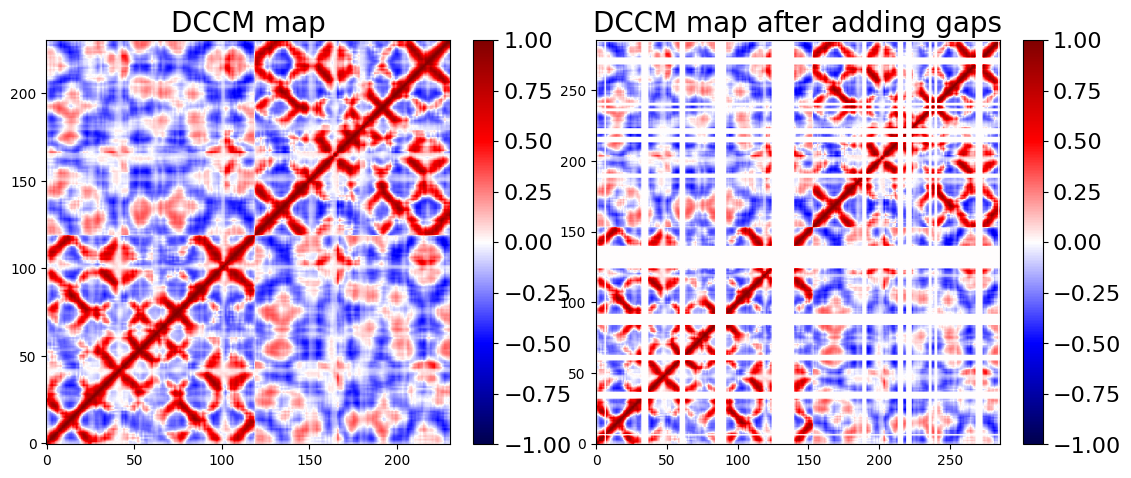

In [20]:
title_size = 20

input_shape = train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(raw_imgs[10], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(train_x[10].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045)
cb2 = plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cb1.ax.tick_params(labelsize=16)
cb2.ax.tick_params(labelsize=16)

plt.show()

In [21]:
labels[10]

'1dbb'

# Training

## Import

In [ ]:
!pip install adabelief_pytorch

In [ ]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.optim import Adam

# from adabelief_pytorch import AdaBelief
from sklearn.model_selection import train_test_split

## Split data

In [ ]:
def create_test_set(train_x, train_y, test_size=None, random_state=0):
    r"""Creates the test set given a set of input images and their corresponding labels.

    Parameters
    ----------
    train_x: numpy.ndarray
        Input normal mode correlation maps.
    train_y: numpy.ndarray
        Labels.
    test_size: float
        Fraction of original samples to be included in the test set.
    random_state: int
        Set lot number.

    Returns
    -------
    train_x: torch.Tensor
        Training inputs.
    test_x: torch.Tensor
        Test inputs.
    train_y: torch.Tensor
        Training labels.
    test_y: torch.Tensor
        Test labels.

    """

    # Splitting
    indices = np.arange(len(train_x))
    train_x, test_x, train_y, test_y, indices_train, indices_test = train_test_split(train_x, train_y, indices, test_size=0.023, random_state=23)

    # Converting to tensors
    train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
    train_x = train_x.astype(np.float32)
    train_x  = torch.from_numpy(train_x)
    train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
    train_y = torch.from_numpy(train_y)

    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[2], test_x.shape[2])
    test_x = test_x.astype(np.float32)
    test_x  = torch.from_numpy(test_x)
    test_y = test_y.astype(np.float32).reshape(test_y.shape[0], 1, 1)
    test_y = torch.from_numpy(test_y)

    return train_x, test_x, train_y, test_y, indices_train, indices_test

In [ ]:
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(train_x, train_y, test_size=0.1)

In [ ]:
train_x.shape

torch.Size([619, 1, 286, 286])

## Model Vim

In [ ]:
!pip install vision-mamba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing i

#### Training

In [ ]:
from vision_mamba.model import Vim

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
2024-12-21 15:59:07.035 | INFO     | zeta.nn.modules.flow_transformer:__init__:221 - Initializing Flow Transformer with config: FlowTransformerConfig(dim=512, heads=8, depth=6, seq_length=1024, flow_hidden_dim=128, flow_steps=4, dropout=0.1, attention_dropout=0.1, learning_rate=0.0001, vocab_size=50000, weight_decay=0.01, warmup_steps=10000, max_steps=100000, batch_size=32, checkpoint_interval=1000, device=device(type='cpu'))
2024-12-21 15:59:07.402 | DEBUG    | zeta.nn.modules.flow_transformer:__init__:74 - Initialized FlowMLP with architecture: Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (2): GELU(approximate='none')
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (5): GELU(approximate='none')
  (6): Linear(in_features=128, out_features=512, bias=True)
)
2024-12

Input shape: torch.Size([4, 512])
Output shape: torch.Size([4, 512, 50000])
Predictions shape: torch.Size([4, 512])


ModuleNotFoundError: No module named 'datasets'

In [ ]:
import torch
import torch.optim as optim
from torch.nn import MSELoss
from torch.utils.data import DataLoader, TensorDataset
from vision_mamba.model import Vim
import numpy as np
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming train_x and train_y are your input arrays
train_x_t = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y_t = torch.tensor(train_y, dtype=torch.float32).to(device)
test_x_t = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y_t = torch.tensor(test_y, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader for training and validation datasets
train_dataset = TensorDataset(train_x_t, train_y_t)
test_dataset = TensorDataset(test_x_t, test_y_t)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the Vim model
model = Vim(
    dim=64,
    dt_rank=16,
    dim_inner=64,
    d_state=64,
    num_classes=1,  # For regression, typically the output is a single value per instance
    image_size=286,
    patch_size=13,
    channels=1,
    dropout=0.2,
    depth=5,
)

# Move the model to the GPU
model.to(device)

# Using Mean Squared Error Loss for a regression task
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Print the model architecture
print(model)

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=13, p2=13)
    (1): Linear(in_features=169, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-4): 5 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=64, out_features=144, bias=False)
        (dt_proj_layer): Linear(in_features=16, out_features=64, bias=True)
      )
      (proj): Linear(in_features=64, out_features=64, bias=True)
      (softplus): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

146497

In [ ]:
# Training loop
model.train()  # Set the model to training mode
num_epochs = epoch  # Define the number of epochs
verbose = True  # Set verbose to True to print correlation

# Initialize lists to store the loss and correlation values for each epoch
train_loss_values = []
train_correlation_values = []
test_loss_values = []
test_correlation_values = []

# Record the start time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode for training loop
    total_loss = 0.0
    num_batches = 0
    outputs_all = []
    targets_all = []

    for batch_inputs, batch_targets in train_loader:
        # Move the inputs and targets to the GPU
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1

        # Debugging shapes
        print("Output shape:", outputs.shape)
        print("Target shape:", batch_targets.shape)

        # Collect outputs and targets for correlation, ensure they are flattened
        outputs_all.append(outputs.view(-1).detach().cpu().numpy())
        targets_all.append(batch_targets.view(-1).detach().cpu().numpy())

    # Calculate average loss for the epoch
    average_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}: Average Loss {average_loss:.4f}')

    # Step the scheduler
    scheduler.step(average_loss)

    # Compute correlation
    outputs_flat = np.concatenate(outputs_all)
    targets_flat = np.concatenate(targets_all)
    corr = np.corrcoef(outputs_flat, targets_flat)[0, 1]
    if verbose:
        print('Epoch {}: Train Correlation: {:.4f}'.format(epoch + 1, corr))

    # Append loss and correlation values to the lists
    train_loss_values.append(average_loss)
    train_correlation_values.append(corr)

    # Evaluate on test set
    model.eval()  # Set the model to evaluation mode
    test_total_loss = 0.0
    test_num_batches = 0
    test_outputs_all = []
    test_targets_all = []

    with torch.no_grad():
        for batch_inputs, batch_targets in test_loader:
            # Move the inputs and targets to the GPU
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

            # Forward pass
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)

            # Accumulate loss
            test_total_loss += loss.item()
            test_num_batches += 1

            # Collect outputs and targets for correlation, ensure they are flattened
            test_outputs_all.append(outputs.view(-1).cpu().numpy())
            test_targets_all.append(batch_targets.view(-1).cpu().numpy())

    # Calculate average test loss for the epoch
    test_average_loss = test_total_loss / test_num_batches
    print(f'Epoch {epoch + 1}: Test Average Loss {test_average_loss:.4f}')

    # Compute test correlation
    test_outputs_flat = np.concatenate(test_outputs_all)
    test_targets_flat = np.concatenate(test_targets_all)
    test_corr = np.corrcoef(test_outputs_flat, test_targets_flat)[0, 1]
    if verbose:
        print('Epoch {}: Test Correlation: {:.4f}'.format(epoch + 1, test_corr))

    # Append test loss and correlation values to the lists
    test_loss_values.append(test_average_loss)
    test_correlation_values.append(test_corr)

# Record the end time
end_time = time.time()

# Calculate and print the total training time
total_training_time = end_time - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

# Save the trained model
current_dir = os.getcwd()
model_save_path = os.path.join(current_dir, 'pengujian_split_data', '97,7-2,3', 'vim', 'vim_model_2.pth')
# model_save_path = 'vim_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Streaming output truncated to the last 5000 lines.
         [18.2316,  1.6594,  0.1022,  ...,  4.3237, 20.1772, 16.8943],
         ...,
         [ 8.8683,  0.0333,  1.3466,  ...,  0.1131,  8.5402,  7.2470],
         [16.6994,  2.1070,  0.2097,  ...,  4.9018, 19.3762, 16.7119],
         [26.2654,  2.1463,  0.1198,  ...,  5.9613, 28.2358, 23.7907]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)
Layer: torch.Size([1, 484, 128])
Conv1d: tensor([[[0.5158, 0.4844, 0.5192,  ..., 0.4431, 0.4376, 0.5152],
         [0.6210, 1.0545, 1.0758,  ..., 1.1472, 0.9551, 0.9008],
         [0.5311, 0.4432, 0.8152,  ..., 0.4770, 0.7012, 0.6640],
         ...,
         [0.7327, 0.5902, 0.4661,  ..., 0.4687, 0.3462, 0.4742],
         [0.5844, 0.4791, 0.9321,  ..., 0.4961, 0.7701, 0.7035],
         [0.6191, 0.4252, 0.6078,  ..., 0.4455, 0.6459, 0.6989]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[0.5566, 0.4938, 0.7569,  ..., 0.5092, 0.7383, 0.7145],
         [0.5686, 0.556

# Predicting

In [ ]:
test_x[10].shape

torch.Size([1, 286, 286])

In [ ]:
test = test_x[10].reshape(1, 1, test_x.shape[-1], test_x.shape[-1])
test.shape

torch.Size([1, 1, 286, 286])

In [ ]:
test_y[10]

tensor([[-5.3098]])

vim

In [ ]:
# Load the model state dictionary
model_load_path = '/content/vim_model.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

model.eval()

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=13, p2=13)
    (1): Linear(in_features=169, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2677301595791723, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-6): 7 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=128, out_features=226, bias=False)
        (dt_proj_layer): Linear(in_features=32, out_features=128, bias=True)
      )
      (proj): Linear(in_features=128, out_features=128, bias=True)
      (softplus): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((128,), eps=1e-05, elementwise_affin

In [ ]:
print('The output value is ' + str(model(test)[0].detach().numpy()[0]))
print('So the predicted binding affinity is ' + str(10**model(test)[0].detach().numpy()[0]))

Patch embedding: torch.Size([1, 484, 128])
Cls tokens: torch.Size([1, 1, 128])
torch.Size([1, 484, 128])
Conv1d: tensor([[[0.9474, 0.6807, 0.2928,  ..., 0.6029, 0.6420, 1.2937],
         [0.7916, 0.4245, 0.4723,  ..., 0.5548, 0.4489, 0.9730],
         [0.1153, 0.3094, 1.7163,  ..., 0.2363, 0.4514, 0.0484],
         ...,
         [0.4750, 0.5934, 0.4259,  ..., 0.5131, 0.4892, 0.4919],
         [0.5604, 0.2781, 0.6260,  ..., 0.2975, 0.6887, 0.6320],
         [1.0489, 0.9131, 0.2524,  ..., 1.0984, 0.4901, 1.0252]]],
       grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[1.3666, 0.7755, 0.8540,  ..., 0.5437, 1.3403, 1.5644],
         [0.4224, 0.6733, 1.8863,  ..., 0.4453, 0.9782, 0.3074],
         [0.3935, 0.7531, 1.2295,  ..., 0.3327, 1.3550, 0.4290],
         ...,
         [0.1077, 0.3345, 0.2452,  ..., 0.4059, 0.2080, 0.1053],
         [0.3135, 0.6344, 1.8774,  ..., 0.1805, 0.8599, 0.3511],
         [0.6303, 0.4604, 0.1978,  ..., 1.1164, 0.4003, 0.7945]]],
       grad_fn=<SoftplusBackwar

## all data

### Vim

In [ ]:
# Load the model state dictionary
model_load_path = '/content/vim_model.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

model.eval()

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=13, p2=13)
    (1): Linear(in_features=169, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2677301595791723, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-6): 7 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=128, out_features=226, bias=False)
        (dt_proj_layer): Linear(in_features=32, out_features=128, bias=True)
      )
      (proj): Linear(in_features=128, out_features=128, bias=True)
      (softplus): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((128,), eps=1e-05, elementwise_affin

In [ ]:
# Initialize an empty DataFrame with the required columns
results_df = pd.DataFrame(columns=['Predicted Output', 'Predicted Affinity', 'True Output'])

# Loop through the test data
for i in range(len(test_x)):
    # Reshape the test data
    test = test_x[i].reshape(1, 1, test_x.shape[-1], test_x.shape[-1])

    # Make the prediction
    predicted_output = str(model(test)[0].detach().numpy()[0])

    # Calculate the predicted affinity
    predicted_affinity = str(10**model(test)[0].detach().numpy()[0])

    # Get the true output
    true_output = test_y[i].detach().numpy()[0, 0]

    # Append the results to the DataFrame using loc
    results_df.loc[i] = [predicted_output, predicted_affinity, true_output]


Patch embedding: torch.Size([1, 484, 128])
Cls tokens: torch.Size([1, 1, 128])
torch.Size([1, 484, 128])
Conv1d: tensor([[[0.9249, 0.7178, 0.2869,  ..., 0.5196, 0.4993, 1.3011],
         [0.7760, 0.4376, 0.4313,  ..., 0.5649, 0.4164, 0.9979],
         [0.1202, 0.2375, 1.7755,  ..., 0.2755, 0.7107, 0.0458],
         ...,
         [0.4820, 0.5919, 0.4192,  ..., 0.4678, 0.5215, 0.4858],
         [0.5272, 0.3191, 0.6289,  ..., 0.3053, 0.6699, 0.6618],
         [1.1139, 0.9709, 0.2786,  ..., 0.9981, 0.3965, 1.0225]]],
       grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[1.3508, 0.8164, 0.8372,  ..., 0.5399, 1.1844, 1.5707],
         [0.4577, 0.5532, 1.9323,  ..., 0.4755, 1.0590, 0.3012],
         [0.3969, 0.7512, 1.1966,  ..., 0.3126, 1.4273, 0.4065],
         ...,
         [0.1197, 0.2709, 0.3009,  ..., 0.3948, 0.1987, 0.1015],
         [0.3392, 0.5970, 1.7404,  ..., 0.1790, 1.0184, 0.3512],
         [0.6383, 0.5206, 0.2031,  ..., 1.1245, 0.4257, 0.7951]]],
       grad_fn=<SoftplusBackwar

In [ ]:
results_df

,Predicted Output,Predicted Affinity,True Output
0,-6.3564553,4.4009321591704205e-07,-6.420217
1,-7.434359,3.678247312783554e-08,-7.142667
2,-8.742572,1.8089566905615997e-09,-8.050610
3,-8.099307,7.955966389636495e-09,-7.036212
4,-8.241764,5.73107288179903e-09,-9.273273
5,-8.108464,7.78996953023637e-09,-8.164310
6,-8.161515,6.894214064936733e-09,-7.920819
7,-8.109573,7.770100493830212e-09,-6.838632
8,-10.748591,1.784056388516652e-11,-11.244125
9,-7.54509,2.850426201688455e-08,-7.853872
